<a href="https://colab.research.google.com/github/shubacca/Take-Home-Challenges/blob/master/Forecasting_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial from https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

In [1]:
!pip install numpy pandas matplotlib plotly scikit-learn xgboost lightgbm catboost skforecast shap astral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", whi

In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version xgboost: {xgboost.__version__}")
print(f"{color}Version catboost: {catboost.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




Version skforecast: 0.13.0
Version scikit-learn: 1.3.2
Version lightgbm: 4.4.0
Version xgboost: 2.1.1
Version catboost: 1.2.5
Version pandas: 2.1.4
Version numpy: 1.26.4


In [3]:
# Downloading data
# ==============================================================================
data = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


In [4]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
data = data[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
if pd.__version__ < '2.2':
    data = data.asfreq('H')
else:
    data = data.asfreq('h')
data = data.sort_index()
data.head()

,users,holiday,weather,temp,atemp,hum,windspeed
date_time,,,,,,,
2011-01-01 00:00:00,16.0,0.0,clear,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,40.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,32.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,13.0,0.0,clear,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,clear,9.84,14.395,75.0,0.0


In [5]:
data.index.min(), data.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))

In [6]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


In [7]:
# prompt: a slider using jupyter widgets

import ipywidgets as widgets
from IPython.display import display

def plot_zoom(zoom_start, zoom_end):
    zoom = (zoom_start, zoom_end)
    fig = plt.figure(figsize=(8, 4))
    grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)
    main_ax = fig.add_subplot(grid[1:3, :])

    data_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
    data_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
    data_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
    min_y = min(data['users'])
    max_y = max(data['users'])
    main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
    main_ax.set_title(f'Number of users: {data.index.min()}, {data.index.max()}', fontsize=10)
    main_ax.set_xlabel('')
    main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
    zoom_ax = fig.add_subplot(grid[5:, :])
    data.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
    zoom_ax.set_title(f'Number of users: {zoom}', fontsize=10)
    zoom_ax.set_xlabel('')
    plt.subplots_adjust(hspace=1)
    plt.show()

# Create sliders for zoom start and end
zoom_start_slider = widgets.SelectionSlider(
    options=data.index.strftime('%Y-%m-%d %H:%M:%S').tolist(),
    description='Zoom Start:',
    continuous_update=False
)

zoom_end_slider = widgets.SelectionSlider(
    options=data.index.strftime('%Y-%m-%d %H:%M:%S').tolist(),
    description='Zoom End:',
    continuous_update=False
)

# Interactive plot
widgets.interact(plot_zoom, zoom_start=zoom_start_slider, zoom_end=zoom_end_slider);


interactive(children=(SelectionSlider(continuous_update=False, description='Zoom Start:', options=('2011-01-01…

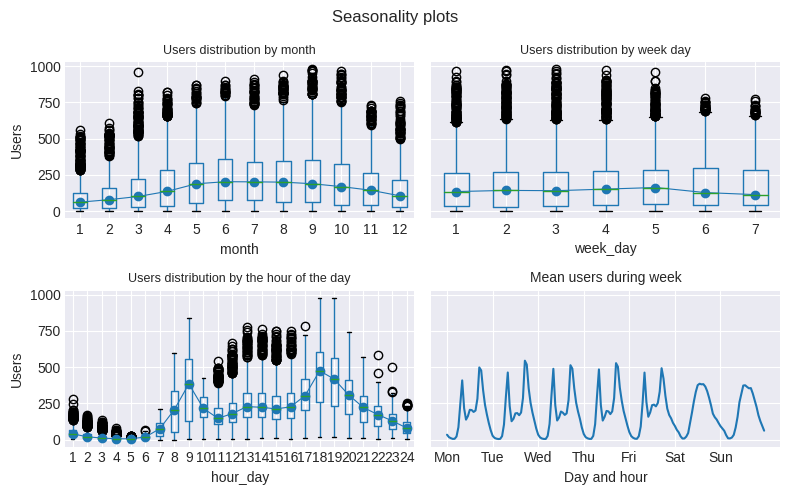

In [10]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
data['month'] = data.index.month
data.boxplot(column='users', by='month', ax=axs[0])
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month', fontsize=9)

# Users distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='users', by='week_day', ax=axs[1])
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day', fontsize=9)

# Users distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='users', by='hour_day', ax=axs[2])
data.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day', fontsize=9)

# Users distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)
axs[3].title.set_size(10)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

There is a clear difference between weekdays and weekends. There is also a clear intra-day pattern, with a different influx of users depending on the time of day.

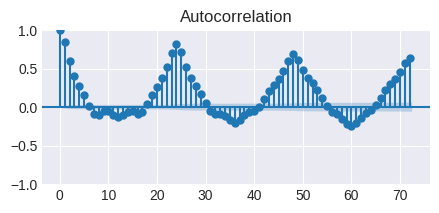

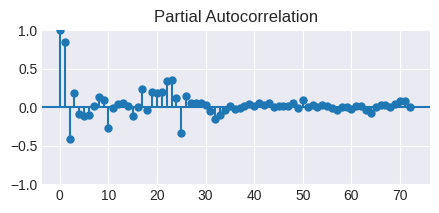

In [11]:
# draw the autocorrelation plot and the partial ACF plot
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

# Partial ACF plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['users'], ax=ax, lags=72)
plt.show()

In [ ]:
# prompt: how to interpret the above ACF and PACF graphs? what is the difference between the two ?

#Interpreting ACF and PACF graphs

#ACF (Autocorrelation Function) Plot:
# - Measures the linear relationship between a time series and its lagged values.
# - Each bar represents the correlation at a specific lag (time shift).
# - Positive values indicate a positive correlation (high values tend to follow high values),
#   negative values indicate a negative correlation (high values tend to follow low values).
# - The height of the bar indicates the strength of the correlation.
# - Helps identify the order of moving average (MA) terms in a time series model.

#PACF (Partial Autocorrelation Function) Plot:
# - Measures the correlation between a time series and its lagged values,
#   after removing the effects of correlations at shorter lags.
# - Helps identify the order of autoregressive (AR) terms in a time series model.

#Difference between ACF and PACF:
# - ACF considers the direct and indirect correlations between a time series and its lags.
# - PACF isolates the direct correlation between a time series and a specific lag,
#   excluding the influence of intermediate lags.

#How to Interpret the Plots:
# - Look for significant spikes (bars that extend beyond the confidence intervals).
# - In the ACF plot, significant spikes suggest the presence of MA terms.
# - In the PACF plot, significant spikes suggest the presence of AR terms.
# - The lag at which the spikes occur indicates the order of the corresponding terms.

#In your specific case, you'll need to analyze the ACF and PACF plots to determine
#the appropriate AR and MA terms for your time series model.
#This will help you capture the underlying patterns and make accurate predictions.


In [12]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Creation date: 2024-08-13 17:39:01 
Last fit date: 2024-08-13 17:39:01 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecaster id: None 

In [13]:
# Backtesting
# ==============================================================================
metric_baseline, predictions = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['users'],
                                   steps              = 36,
                                   metric             = 'mean_absolute_error',
                                   initial_train_size = len(data.loc[:end_validation]),
                                   refit              = False,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )
metric_baseline

  0%|          | 0/82 [00:00<?, ?it/s]

,mean_absolute_error
0,91.668716


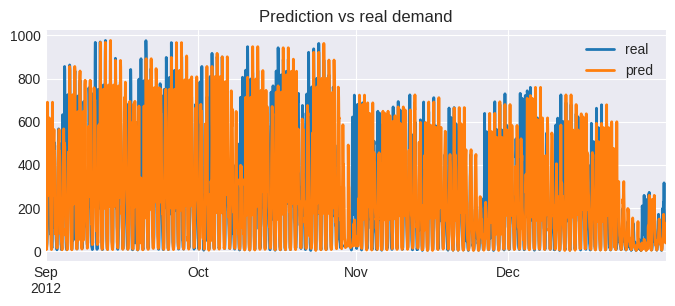

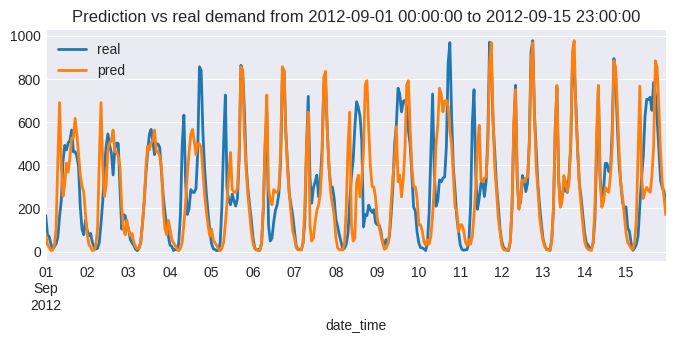

In [14]:
# prompt: i want to plot the forecasted predictions along with actuals for a 2 week window only

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[predictions.index, 'users'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(ax=ax, linewidth=2, label='prediction')
ax.set_title('Prediction vs real demand')
ax.legend();

# Zoom prediction
# ==============================================================================
zoom = ('2012-09-01 00:00:00','2012-09-15 23:00:00')

fig, ax = plt.subplots(figsize=(8, 3))
data.loc[zoom[0]: zoom[1], 'users'].plot(ax=ax, linewidth=2, label='real')
predictions.loc[zoom[0]: zoom[1]].plot(ax=ax, linewidth=2, label='prediction')
ax.set_title(f'Prediction vs real demand from {zoom[0]} to {zoom[1]}')
ax.legend();


Recursive multi-step forecasting with LightGBM

In [15]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-08-13 17

In [ ]:
# prompt: what does the above forecaster do?

# The forecaster is an autoregressive model that uses the LGBMRegressor (LightGBM regression algorithm) to predict future values of a time series based on its past values (lags).

# Here's a breakdown of what it does:

# 1. Autoregressive Model (ForecasterAutoreg):
#    - It assumes that future values of the time series are a function of its past values.
#    - It uses lagged values (previous observations) as input features to predict future values.

# 2. LightGBM Regressor (LGBMRegressor):
#    - It's a gradient boosting framework that uses tree-based learning algorithms.
#    - Known for its high efficiency, accuracy, and ability to handle large datasets.
#    - It learns the relationship between the lagged values (input features) and the target values (future time series values).

# 3. Lags (lags = 24):
#    - Specifies the number of past time steps to use as input features.
#    - In this case, it uses the values from the previous 24 hours to predict the next hour's value.

# In essence, the forecaster takes the past 24 hours of 'users' data as input,
# uses the LightGBM algorithm to learn the patterns in this data,
# and then predicts the number of users for the next hour.
# This process is repeated recursively to generate multi-step forecasts.


In [16]:
# Predict
# ==============================================================================
forecaster.predict(steps=10)

,pred
2012-09-01 00:00:00,110.553303
2012-09-01 01:00:00,75.218776
2012-09-01 02:00:00,42.928564
2012-09-01 03:00:00,24.890883
2012-09-01 04:00:00,10.654948
2012-09-01 05:00:00,16.922900
2012-09-01 06:00:00,41.333408
2012-09-01 07:00:00,92.882118
2012-09-01 08:00:00,221.375747
2012-09-01 09:00:00,374.074368


In [25]:
forecaster.create_train_X_y(y=data.loc[:end_validation, 'users'])[0]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-02 00:00:00,39.0,28.0,34.0,36.0,37.0,35.0,67.0,93.0,110.0,106.0,...,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0,16.0
2011-01-02 01:00:00,17.0,39.0,28.0,34.0,36.0,37.0,35.0,67.0,93.0,110.0,...,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0
2011-01-02 02:00:00,17.0,17.0,39.0,28.0,34.0,36.0,37.0,35.0,67.0,93.0,...,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0
2011-01-02 03:00:00,9.0,17.0,17.0,39.0,28.0,34.0,36.0,37.0,35.0,67.0,...,84.0,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0
2011-01-02 04:00:00,6.0,9.0,17.0,17.0,39.0,28.0,34.0,36.0,37.0,35.0,...,94.0,84.0,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-31 19:00:00,546.0,617.0,528.0,526.0,436.0,368.0,410.0,309.0,256.0,398.0,...,7.0,5.0,20.0,32.0,82.0,152.0,291.0,307.0,471.0,610.0
2012-08-31 20:00:00,452.0,546.0,617.0,528.0,526.0,436.0,368.0,410.0,309.0,256.0,...,29.0,7.0,5.0,20.0,32.0,82.0,152.0,291.0,307.0,471.0
2012-08-31 21:00:00,356.0,452.0,546.0,617.0,528.0,526.0,436.0,368.0,410.0,309.0,...,108.0,29.0,7.0,5.0,20.0,32.0,82.0,152.0,291.0,307.0


In [26]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          steps              = 36,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          skip_folds         = None,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )
predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 14616
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 12 observations.

Fold: 0
    Training:   2011-01-01 00:00:00 -- 2012-08-31 23:00:00  (n=14616)
    Validation: 2012-09-01 00:00:00 -- 2012-09-02 11:00:00  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 2012-09-02 12:00:00 -- 2012-09-03 23:00:00  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 2012-09-04 00:00:00 -- 2012-09-05 11:00:00  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 2012-09-05 12:00:00 -- 2012-09-06 23:00:00  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 2012-09-07 00:00:00 -- 2012-09-08 11:00:00  (n=36)


  0%|          | 0/82 [00:00<?, ?it/s]

,pred
2012-09-01 00:00:00,110.553303
2012-09-01 01:00:00,75.218776
2012-09-01 02:00:00,42.928564
2012-09-01 03:00:00,24.890883
2012-09-01 04:00:00,10.654948


In [27]:
# Backtesting error
# ==============================================================================
metric

,mean_absolute_error
0,76.258681


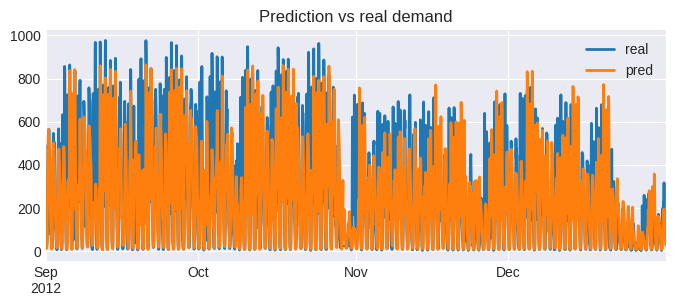

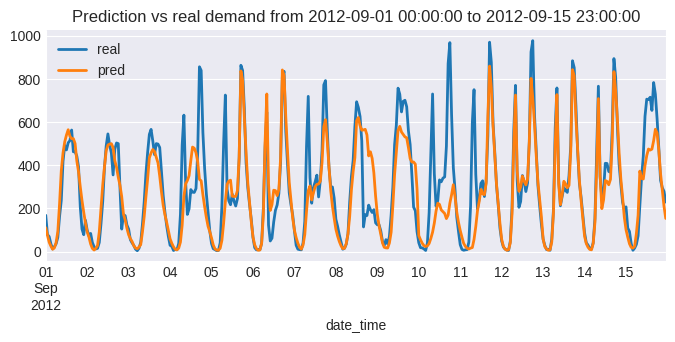

In [28]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[predictions.index, 'users'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(ax=ax, linewidth=2, label='prediction')
ax.set_title('Prediction vs real demand')
ax.legend();

# Zoom prediction
# ==============================================================================
zoom = ('2012-09-01 00:00:00','2012-09-15 23:00:00')

fig, ax = plt.subplots(figsize=(8, 3))
data.loc[zoom[0]: zoom[1], 'users'].plot(ax=ax, linewidth=2, label='real')
predictions.loc[zoom[0]: zoom[1]].plot(ax=ax, linewidth=2, label='prediction')
ax.set_title(f'Prediction vs real demand from {zoom[0]} to {zoom[1]}')
ax.legend();

In [29]:
# Bayesian Hyperparameter search
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, 'users'], # Test data not used
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    fixed_train_size   = False,
    n_trials           = 20, # Increase this value for a more exhaustive search
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1100, 'max_depth': 8, 'min_data_in_leaf': 425, 'learning_rate': 0.07002735285634536, 'feature_fraction': 0.6, 'max_bin': 75, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004}
  Backtesting metric: 68.33537644642092



In [31]:
# Search results
# ==============================================================================
results_search.head(10)

,lags,params,mean_absolute_error,n_estimators,max_depth,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
19,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1100, 'max_depth': 8, 'min_da...",68.335376,1100.0,8.0,425.0,0.070027,0.6,75.0,0.4,0.3
14,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",69.194709,1200.0,10.0,464.0,0.137025,0.9,75.0,0.2,0.3
15,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 900, 'max_depth': 8, 'min_dat...",69.316631,900.0,8.0,460.0,0.144455,0.8,100.0,0.2,0.4
1,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1000, 'max_depth': 6, 'min_da...",69.399878,1000.0,6.0,53.0,0.205042,0.9,75.0,0.1,0.5
10,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",69.587667,1200.0,10.0,47.0,0.013950,1.0,50.0,0.0,0.2
3,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 6, 'min_dat...",69.668446,800.0,6.0,173.0,0.218912,1.0,250.0,0.5,0.6
17,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 400, 'max_depth': 8, 'min_dat...",70.008581,400.0,8.0,491.0,0.131761,0.8,100.0,0.2,0.4
13,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 900, 'max_depth': 8, 'min_dat...",70.130838,900.0,8.0,207.0,0.363259,1.0,75.0,0.0,0.0
16,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 9, 'min_dat...",70.142015,800.0,9.0,493.0,0.119178,0.6,125.0,0.3,0.4
11,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",70.276072,1200.0,10.0,31.0,0.017627,1.0,50.0,0.0,0.2


In [32]:
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterAutoreg 
Regressor: LGBMRegressor(feature_fraction=0.6, learning_rate=0.07002735285634536,
              max_bin=75, max_depth=8, min_data_in_leaf=425, n_estimators=1100,
              random_state=15926, reg_alpha=0.4, reg_lambda=0.30000000000000004,
              verbose=-1) 
Lags: [  1   2   3  23  24  25 167 168 169] 
Transformer for y: None 
Transformer for exog: None 
Window size: 169 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.07002735285634536, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1100, 'n_jobs': None, 'num_leaves': 31, 'objective': N

In [ ]:
# prompt: what does lag_grid [  1   2   3  23  24  25 167 168 169]  mean above

# The lag grid [1, 2, 3, 23, 24, 25, 167, 168, 169] represents a set of options for the number of past time steps
#  (lags) to consider as input features for the time series forecasting model.

# Each number in the list corresponds to a potential lag value. For example:
# - 1: Use the value from the previous hour as a feature.
# - 2: Use the values from the previous two hours as features.
# - 24: Use the values from the previous 24 hours (one day) as features.
# - 168: Use the values from the previous 168 hours (one week) as features.

# During the hyperparameter search (bayesian_search_forecaster), the algorithm will try different combinations of lags
# from this grid to find the optimal set of lags that leads to the best forecasting performance.

# The choice of lags is crucial because it determines how much historical information the model uses to make predictions.
# Using too few lags might not capture long-term patterns, while using too many lags might introduce noise and overfitting.

# The specific lags in this grid seem to be chosen based on domain knowledge or prior analysis. For instance:
# - Lags 1, 2, 3 might capture short-term hourly patterns.
# - Lags 23, 24, 25 might capture daily patterns.
# - Lags 167, 168, 169 might capture weekly patterns.

# By exploring different combinations of these lags, the hyperparameter search aims to find the best way to leverage historical data for accurate forecasting.


In [33]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          steps              = 36,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )
display(metric)
predictions.head()

  0%|          | 0/82 [00:00<?, ?it/s]

,mean_absolute_error
0,67.373324


,pred
2012-09-01 00:00:00,131.093298
2012-09-01 01:00:00,97.258305
2012-09-01 02:00:00,65.512600
2012-09-01 03:00:00,34.881848
2012-09-01 04:00:00,10.742675


from matplotlib import pyplot as plt
_df_30['pred'].plot(kind='hist', bins=20, title='pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['pred'].plot(kind='line', figsize=(8, 4), title='pred')
plt.gca().spines[['top', 'right']].set_visible(False)

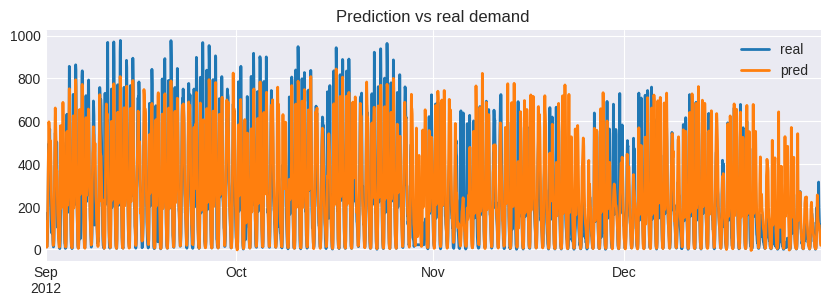

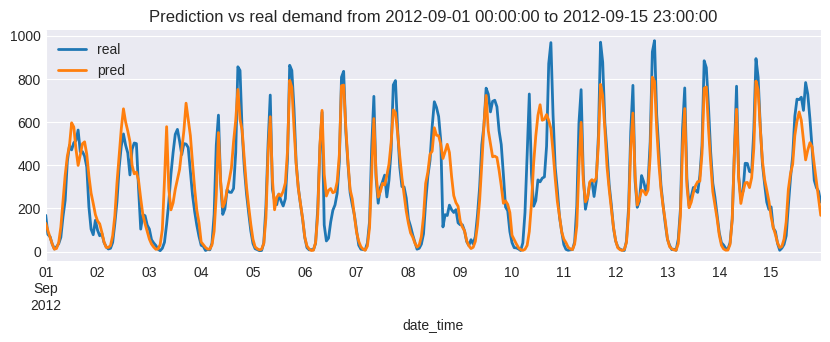

In [36]:
# prompt: i want to plot predictions vs real values

# Plot predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
data.loc[predictions.index, 'users'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(ax=ax, linewidth=2, label='prediction')
ax.set_title('Prediction vs real demand')
ax.legend();
# Zoom prediction
# ==============================================================================
zoom = ('2012-09-01 00:00:00','2012-09-15 23:00:00')

fig, ax = plt.subplots(figsize=(10, 3))
data.loc[zoom[0]: zoom[1], 'users'].plot(ax=ax, linewidth=2, label='real')
predictions.loc[zoom[0]: zoom[1]].plot(ax=ax, linewidth=2, label='prediction')
ax.set_title(f'Prediction vs real demand from {zoom[0]} to {zoom[1]}')
ax.legend();

In [37]:
# Next, the predictive capacity of the model is evaluated when exogenous variables are added.

In [30]:
# Calendar features
# ==============================================================================
calendar_features = pd.DataFrame(index=data.index)
calendar_features['month'] = calendar_features.index.month
calendar_features['week_of_year'] = calendar_features.index.isocalendar().week
calendar_features['week_day'] = calendar_features.index.day_of_week + 1
calendar_features['hour_day'] = calendar_features.index.hour + 1
calendar_features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,month,week_of_year,week_day,hour_day
date_time,,,,
2011-01-01 00:00:00,1,52,6,1
2011-01-01 01:00:00,1,52,6,2
2011-01-01 02:00:00,1,52,6,3
2011-01-01 03:00:00,1,52,6,4
2011-01-01 04:00:00,1,52,6,5
...,...,...,...,...
2012-12-31 19:00:00,12,1,1,20
2012-12-31 20:00:00,12,1,1,21
2012-12-31 21:00:00,12,1,1,22


In [31]:
# Sunlight features
# ==============================================================================
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour},
                         index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features["is_daylight"] = np.where(
    (data.index.hour >= sun_light_features["sunrise_hour"])
    & (data.index.hour < sun_light_features["sunset_hour"]),
    1,
    0,
)
sun_light_features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,sunrise_hour,sunset_hour,daylight_hours,is_daylight
date_time,,,,
2011-01-01 00:00:00,7,16,9,0
2011-01-01 01:00:00,7,16,9,0
2011-01-01 02:00:00,7,16,9,0
2011-01-01 03:00:00,7,16,9,0
2011-01-01 04:00:00,7,16,9,0
...,...,...,...,...
2012-12-31 19:00:00,7,16,9,0
2012-12-31 20:00:00,7,16,9,0
2012-12-31 21:00:00,7,16,9,0


In [32]:

# Holiday features
# ==============================================================================
holiday_features = data[['holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['holiday'].shift(-24)
holiday_features

,holiday,holiday_previous_day,holiday_next_day
date_time,,,
2011-01-01 00:00:00,0,NaN,0.0
2011-01-01 01:00:00,0,NaN,0.0
2011-01-01 02:00:00,0,NaN,0.0
2011-01-01 03:00:00,0,NaN,0.0
2011-01-01 04:00:00,0,NaN,0.0
...,...,...,...
2012-12-31 19:00:00,0,0.0,NaN
2012-12-31 20:00:00,0,0.0,NaN
2012-12-31 21:00:00,0,0.0,NaN


In [33]:
# Temperature features
# ==============================================================================
temp_features = data[['temp']].copy()
temp_features['temp_roll_mean_1_day'] = temp_features['temp'].rolling(24, closed='left').mean()
temp_features['temp_roll_mean_7_day'] = temp_features['temp'].rolling(24*7, closed='left').mean()
temp_features['temp_roll_max_1_day'] = temp_features['temp'].rolling(24, closed='left').max()
temp_features['temp_roll_min_1_day'] = temp_features['temp'].rolling(24, closed='left').min()
temp_features['temp_roll_max_7_day'] = temp_features['temp'].rolling(24*7, closed='left').max()
temp_features['temp_roll_min_7_day'] = temp_features['temp'].rolling(24*7, closed='left').min()
temp_features

,temp,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day
date_time,,,,,,,
2011-01-01 00:00:00,9.84,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,9.02,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,9.02,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,9.84,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 04:00:00,9.84,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,10.66,8.610000,10.318333,13.94,5.74,16.4,5.74
2012-12-31 20:00:00,10.66,8.473333,10.323214,11.48,5.74,16.4,5.74
2012-12-31 21:00:00,10.66,8.541667,10.328095,11.48,5.74,16.4,5.74


In [34]:
# Merge all exogenous variables
# ==============================================================================
df_exogenous_features = pd.concat([
    calendar_features,
    sun_light_features,
    temp_features,
    holiday_features
], axis=1)

df_exogenous_features.head(4)

,month,week_of_year,week_day,hour_day,sunrise_hour,sunset_hour,daylight_hours,is_daylight,temp,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday,holiday_previous_day,holiday_next_day
date_time,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 03:00:00,1,52,6,4,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0


In [35]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(df_exogenous_features['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(df_exogenous_features['week_of_year'], cycle_length=52)
week_day_encoded = cyclical_encoding(df_exogenous_features['week_day'], cycle_length=7)
hour_day_encoded = cyclical_encoding(df_exogenous_features['hour_day'], cycle_length=24)
sunrise_hour_encoded = cyclical_encoding(df_exogenous_features['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = cyclical_encoding(df_exogenous_features['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

df_exogenous_features = pd.concat([df_exogenous_features, cyclical_features], axis=1)
df_exogenous_features.head(3)

,month,week_of_year,week_day,hour_day,sunrise_hour,sunset_hour,daylight_hours,is_daylight,temp,temp_roll_mean_1_day,...,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,sunrise_hour_sin,sunrise_hour_cos,sunset_hour_sin,sunset_hour_cos
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,...,0.0,1.0,-0.781831,0.62349,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,...,0.0,1.0,-0.781831,0.62349,0.500000,0.866025,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,...,0.0,1.0,-0.781831,0.62349,0.707107,0.707107,0.965926,-0.258819,-0.866025,-0.5


In [36]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
).set_output(transform="pandas")

poly_cols = [
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'temp',
    'holiday'
]

poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)
df_exogenous_features.head(4)

,month,week_of_year,week_day,hour_day,sunrise_hour,sunset_hour,daylight_hours,is_daylight,temp,temp_roll_mean_1_day,...,poly_temp_roll_min_1_day__temp_roll_max_7_day,poly_temp_roll_min_1_day__temp_roll_min_7_day,poly_temp_roll_min_1_day__temp,poly_temp_roll_min_1_day__holiday,poly_temp_roll_max_7_day__temp_roll_min_7_day,poly_temp_roll_max_7_day__temp,poly_temp_roll_max_7_day__holiday,poly_temp_roll_min_7_day__temp,poly_temp_roll_min_7_day__holiday,poly_temp__holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,1,52,6,4,7,16,9,0,9.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Store categorical variables as category type
# ==============================================================================
data["weather"] = data["weather"].astype("category")

In [38]:
# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [39]:
# Create a forecaster with a transformer for exogenous features
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = one_hot_encoder
)

In [40]:
# View training matrix
# ==============================================================================
exog_features = ['weather']
X_train, y_train = forecaster.create_train_X_y(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)
X_train.head(5)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,weather_clear,weather_mist,weather_rain
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-04 00:00:00,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,72.0,77.0,...,2.0,1.0,1.0,13.0,32.0,40.0,16.0,1.0,0.0,0.0
2011-01-04 01:00:00,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,72.0,...,3.0,2.0,1.0,1.0,13.0,32.0,40.0,1.0,0.0,0.0
2011-01-04 02:00:00,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,...,8.0,3.0,2.0,1.0,1.0,13.0,32.0,1.0,0.0,0.0
2011-01-04 03:00:00,1.0,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,...,14.0,8.0,3.0,2.0,1.0,1.0,13.0,1.0,0.0,0.0
2011-01-04 04:00:00,1.0,1.0,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,...,36.0,14.0,8.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0


In [41]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [42]:
# Create a forecaster with automatic categorical detection
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

In [43]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(df_exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# columns that start with temp_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^temp_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^holiday_.*').columns.tolist())
exog_features.extend(['temp', 'holiday', 'weather'])

df_exogenous_features = df_exogenous_features.filter(exog_features, axis=1)

In [44]:
# Merge target and exogenous variables in the same dataframe
# ==============================================================================
data = data[['users', 'weather']].merge(
    df_exogenous_features,
    left_index=True,
    right_index=True,
    how='left'
)

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
# Numeric columns are cast to float32.
data = data.dropna()
data = data.astype({col: np.float32 for col in data.select_dtypes("number").columns})
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

In [46]:
data.head()

,users,weather,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,...,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day,temp,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,25.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.258819,0.965926,...,8.063334,10.127976,9.02,6.56,18.860001,4.92,0.0,0.0,7.38,0.0
2011-01-08 01:00:00,16.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.500000,0.866025,...,8.029166,10.113334,9.02,6.56,18.860001,4.92,0.0,0.0,7.38,0.0
2011-01-08 02:00:00,16.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.707107,0.707107,...,7.995000,10.103572,9.02,6.56,18.860001,4.92,0.0,0.0,7.38,0.0
2011-01-08 03:00:00,7.0,rain,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.866025,0.500000,...,7.960834,10.093809,9.02,6.56,18.860001,4.92,0.0,0.0,7.38,0.0
2011-01-08 04:00:00,1.0,rain,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.965926,0.258819,...,7.926667,10.079166,9.02,6.56,18.860001,4.92,0.0,0.0,7.38,0.0


In [63]:
# Hyperparameters search
# ==============================================================================
# Create forecaster with a transformer categorical features
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Lags grid
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, 'users'],
    exog               = data.loc[:end_validation, exog_features],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    fixed_train_size   = False,
    n_trials           = 25,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]

  0%|          | 0/25 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 800, 'max_depth': 9, 'min_data_in_leaf': 269, 'learning_rate': 0.010035818244859579, 'feature_fraction': 0.6, 'max_bin': 50, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
  Backtesting metric: 63.48130784020649



In [64]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['users'],
    exog               = data[exog_features],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data[:end_validation]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metric

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,53.907985


In [1]:
# Feature selection
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
    n_estimators = 100,
    max_depth = 5,
    random_state = 15926,
    verbose = -1
)
forecaster = ForecasterAutoreg(
    regressor        = regressor,
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data_train['users'],
    exog            = data_train[exog_features],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

NameError: name 'LGBMRegressor' is not defined